In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/kalapa/data/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/kalapa/data/test.csv")
sample = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/kalapa/data/simple_submission.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_train.head()

,id,label,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,Field_9,Field_10,Field_11,Field_12,Field_13,Field_14,Field_15,Field_16,Field_17,Field_18,Field_19,Field_20,Field_21,Field_22,Field_23,Field_24,Field_25,Field_26,Field_27,Field_28,Field_29,Field_30,Field_31,Field_32,Field_33,Field_34,Field_35,ngaySinh,namSinh,gioiTinh,...,partner2_H,partner2_K,partner2_L,partner3_A,partner3_B,partner3_C,partner3_D,partner3_E,partner3_F,partner3_G,partner3_H,partner3_K,partner3_L,partner4_A,partner4_B,partner4_C,partner4_D,partner4_E,partner4_F,partner4_G,partner4_H,partner4_K,partner4_L,partner5_A,partner5_B,partner5_C,partner5_D,partner5_E,partner5_F,partner5_G,partner5_H,partner5_K,partner5_L,brief,num_of_phone,Field_78,Field_79,Field_80,Field_81,Field_82
0,0,1,2019-07-24T03:39:02.854Z,2019-07-31T20:10:02Z,1.0,GH,2018-12-27,2018-12-27,2019-01-01,2019-07-31,2018-12-27,1.0,2019-07-31,G8,1.0,1.0,NaN,1.0,1.0,Trung tâm Kinh doanh tiền mặt,0.0,4258600.0,4.5,1.0,16.0,1.0,2018-12-27,1.0,0.0,0.0,0.0,1.0,1.0,2018-12-28,2022-09-01,20180107,2019-07-31,19910615.0,0.0,MALE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cb1,1.0,NaN,NaN,NaN,NaN,1
1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.0,NaN,NaN,NaN,NaN,1
2,2,0,2019-01-17T07:15:26.367Z,2019-01-17T07:17:45Z,2.0,T1,2019-01-17,2019-01-17,2019-01-01,2019-12-31,2019-01-17,1.0,NaN,NaN,1.0,1.0,2019-01-17,1.0,1.0,NaN,0.0,5000000.0,4.5,1.0,10.0,1.0,2019-01-17,1.0,0.0,0.0,0.0,1.0,1.0,2019-01-17,2023-03-01,20190102,NaN,19980601.0,0.0,FEMALE,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,33.0,10.769445,6.466667,0.0,2
3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3
4,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3


In [4]:
df_test.head()

,id,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,Field_9,Field_10,Field_11,Field_12,Field_13,Field_14,Field_15,Field_16,Field_17,Field_18,Field_19,Field_20,Field_21,Field_22,Field_23,Field_24,Field_25,Field_26,Field_27,Field_28,Field_29,Field_30,Field_31,Field_32,Field_33,Field_34,Field_35,ngaySinh,namSinh,gioiTinh,diaChi,...,partner2_H,partner2_K,partner2_L,partner3_A,partner3_B,partner3_C,partner3_D,partner3_E,partner3_F,partner3_G,partner3_H,partner3_K,partner3_L,partner4_A,partner4_B,partner4_C,partner4_D,partner4_E,partner4_F,partner4_G,partner4_H,partner4_K,partner4_L,partner5_A,partner5_B,partner5_C,partner5_D,partner5_E,partner5_F,partner5_G,partner5_H,partner5_K,partner5_L,brief,num_of_phone,Field_78,Field_79,Field_80,Field_81,Field_82
0,53030,2019-10-14T01:37:41.959Z,2019-10-14T01:37:41.959Z,2.0,T1,8/27/2019,8/27/2019,9/24/2019,9/23/2020,8/27/2019,1.0,NaN,NaN,1.0,1.0,8/27/2019,1.0,1.0,NaN,0.0,1490000.0,4.5,1.0,43.0,1.0,8/27/2019,1.0,0.0,0.0,12.0,1.0,1.0,8/27/2019,2/24/2021,20190908,NaN,19950425.0,0.0,MALE,"11/1 Tổ 23 KP4, Phường Bửu Long, Thành phố Biê...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,NaN,1
1,53031,2019-09-10T09:20:40.066Z,2019-09-11T07:53:44Z,2.0,T1,9/10/2019,9/10/2019,9/14/2019,9/13/2020,9/10/2019,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,0.0,1043000.0,4.5,1.0,24.0,1.0,9/10/2019,1.0,0.0,0.0,12.0,1.0,1.0,9/11/2019,9/14/2022,20191003,NaN,19920930.0,0.0,MALE,"Xã Chu Minh, Huyện Ba Vì, Thành phố Hà Nội",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notfound,1.0,NaN,NaN,NaN,NaN,1
2,53032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,NaN,NaN,NaN,NaN,1
3,53033,2019-10-21T03:29:30.074Z,2019-10-21T04:17:26Z,2.0,T1,10/21/2019,10/21/2019,11/15/2019,11/14/2020,10/21/2019,1.0,NaN,NaN,1.0,1.0,10/21/2019,1.0,1.0,NaN,0.0,1490000.0,4.5,1.0,0.0,1.0,10/21/2019,1.0,0.0,0.0,12.0,1.0,1.0,10/21/2019,11/15/2024,20191104,NaN,19961208.0,0.0,FEMALE,"Xã Hạ Bằng, Huyện Thạch Thất, Thành phố Hà Nội",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1
4,53034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1.0,27.0,NaN,27.0,27.0,1


In [5]:
index = df_test['id']

In [6]:
print(df_train.shape)
print(df_test.shape)

(53030, 195)
(20381, 194)




1.    Có 195 columns
2.    Mục đích là biến: label
3.    Drop Id nhưng lúc sau ta cần cho quá trình submit
4.    Giá trị còn thiếu rất nhiều



In [7]:
c_train = df_train.copy()
c_test  = df_test.copy()

In [8]:
c_train['train'] = 1
c_test['train'] = 0
df = pd.concat([c_train, c_test], axis=0, sort=False)

### 1. Kiểm tra độ Missing values

In [9]:
#Percentage of NAN Values 
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

Những feature có độ missing lớn hơn 50% giá trị bị thiếu

In [10]:
NAN = NAN[NAN.percentage > 50]
NAN.sort_values("percentage", ascending=False)

,column_name,percentage
36,Field_35,87.455558
13,Field_12,86.484314
12,Field_11,86.414842
19,Field_18,84.462819
74,maCv,83.133318
...,...,...
2,Field_1,52.835406
111,E_endDate,52.147498
110,E_startDate,52.147498
109,E_numQuery,52.147498


Tạm thời cứ để nguyên vậy đợi sau khi group and select thì ta sẽ drop sau

### 2.Processing Columns

#### 2.1 Nhóm I

In [11]:
#xử lí date và dateTime
Date = ['Field_{}'.format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 33, 34, 35, 40]]
DateTime = ['Field_{}'.format(i) for i in [1, 2, 43, 44]]
df[Date + DateTime + ['Field_34']].sample(10)

,Field_5,Field_6,Field_7,Field_8,Field_9,Field_11,Field_15,Field_25,Field_33,Field_34,Field_35,Field_40,Field_1,Field_2,Field_43,Field_44,Field_34
25270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20996,2015-11-26,2015-11-26,2015-11-01,2015-12-31,2015-11-26,NaN,2015-11-26,2015-11-26,NaN,20151104,NaN,NaN,2017-02-07T12:50:36.55Z,2017-02-07T12:50:36.55Z,2017-02-07T10:58:38.657Z,2019-10-22T00:49:55.987Z,20151104
18977,2019-04-25,2019-04-25,2019-05-01,2020-04-30,2019-04-25,NaN,NaN,2019-04-25,2021-05-01,20190504,NaN,2019-05-01,2019-04-24T21:38:07.529Z,2019-04-24T21:38:58Z,2017-02-07T12:08:17.17Z,2017-08-25T09:09:53.89Z,20190504
34242,2019-03-13,2019-03-13,2019-03-13,2019-12-31,2019-03-13,NaN,2019-03-13,2019-03-13,2016-01-01,2.01801e+07,NaN,2019-01-01,2019-03-13T02:07:09.304Z,2019-03-13T02:08:30Z,2017-01-15T03:15:57.237Z,2018-12-03T03:42:44Z,2.01801e+07
21155,2018-12-29,2018-12-29,2019-01-01,2019-02-28,2018-12-29,2019-02-28,NaN,2018-12-29,2023-04-01,20180404,2019-02-28,2019-01-01,2019-02-14T06:52:09.575Z,2019-02-28T20:14:00Z,2017-01-18T12:12:02.937Z,2019-08-26T08:22:41.98Z,20180404
21505,2016-07-01,2016-12-31,2016-07-01,2016-09-30,2016-07-22,2016-10-01,NaN,2016-11-01,NaN,20160713,NaN,NaN,2017-03-24T20:10:37.62Z,2017-03-24T20:10:37.62Z,2017-03-24T14:37:56.11Z,2019-06-26T10:24:56Z,20160713
18355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#hàm chung cho field_34 và ngaySinh
def process_field_34(x):
    if x != x:
        return np.nan
    try:
        x = int(x)
    except ValueError:
        x = x.split(' ')[0]
    
    return datetime.strptime(str(x)[:6], "%Y%m")

In [13]:
#xử lí feature date
#hàm chung cho đối tượng datetime(d-m-y)
def process_date(x):
    if x != x:
        return np.nan
    try:
        date_obj = datetime.strptime(x, '%m/%d/%Y')
    except:
        date_obj = datetime.strptime(x, '%Y-%m-%d')
    return date_obj

#xử lí feature datetime
# xử lí datetime có trong df_all mà có dạng T & Z
def process_datetime(x):
    if x != x:
        return np.nan
    x = x.split('.')[0]
    
    if x[-1] == 'Z':
        x = x[:-1]
    date, time = x.split('T')
    datetime_obj = datetime.strptime(x, "%Y-%m-%dT%H:%M:%S")
    return datetime_obj

In [14]:
# Xử lí nhóm thứ nhất
def process_nhom_I_cols(df):
    cat_cols = []
    for col in Date:
        if col == 'Field_34':
            continue
        df[col] = df[col].apply(process_date) #gọi lại hàm xử lí đối tượng 'date'
        
    for col in DateTime:
        df[col] = df[col].apply(process_datetime) #gọi lại hàm xử lí 'datetime'
 
    df['Field_34'] = df['Field_34'].apply(process_field_34) #gọi lại hàm xử lí 'field_34'
    #df['ngaySinh'] = df['ngaySinh'].apply(process_field_34)
    cat_cols += Date + DateTime
    for col in Date + DateTime:
        df[col] = df[col].dt.strftime('%m-%Y')
    
    # các cọt có ngày tháng năm có trong _startDate và _endDate
    for cat in ['F', 'E', 'C', 'G', 'A']:
        df[f'{cat}_startDate'] = pd.to_datetime(df[f"{cat}_startDate"], infer_datetime_format=True)
        df[f'{cat}_endDate'] = pd.to_datetime(df[f"{cat}_endDate"], infer_datetime_format=True)
        
        df[f'{cat}_startDate'] = df[f'{cat}_startDate'].dt.strftime('%m-%Y')
        df[f'{cat}_endDate'] = df[f'{cat}_endDate'].dt.strftime('%m-%Y')
        
        cat_cols.append(f'{cat}_startDate')
        cat_cols.append(f'{cat}_endDate')
    
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    return df

#### 2.2 Nhóm II

In [15]:
# Trong nhóm II có 6 cột thỏa mãn: CJ, CK, CL, CM, CN, CO (số)
# Có nhiều số 0 trong các cột này (dựa vào tableu) gây nhiễu, loại bỏ
def prepare_process_II(df):
    df = str(df).strip().lower()
    df = re.sub(' +', ' ', df)
    return df

def process_II_cols(df):
    for col in ['currentLocationLocationId', 'currentLocationLatitude', 'currentLocationLongitude',
                'homeTownLocationId', 'homeTownLatitude', 'homeTownLongitude']:
        df[col].replace(0, np.nan, inplace=True)
    df['currentLocationLocationId'] = df['currentLocationLocationId'].apply(prepare_process_II).astype('category')
    df['homeTownLocationId'] = df['homeTownLocationId'].apply(prepare_process_II).astype('category')
    return df

#### 2.3 Nhóm III

In [16]:
def prepare_process_III(df):
    df = str(df).strip().lower()
    df = re.sub(' + ', ' ', df)
    return df

def job_category(x):
    if type(x) == str:
        if "công nhân" in x or "cnv" in x or "cn" in x or "may công nghiệp" in x or "lao động" in x\
        or "thợ" in x or "coõng nhaõn trửùc tieỏp maựy may coõng nghieọp" in x or "c.n" in x or "lđ" in x\
        or "CN" in x or "CNhân" in x or "Cnhân" in x or "CNV" in x:
            return "CN"
        elif "giáo viên" in x or "gv" in x or "gíao viên" in x:
            return "GV"
        elif "nhân viên" in x or "kế toán" in x or "cán bộ" in x or "nv" in x or "cb" in x or "nhõn viờn" in x:
            return "NV"
        elif "tài xế" in x or "lái" in x or "tài xê" in x:
            return "TX"
        elif "quản lý" in x or "phó phòng" in x or "hiệu phó" in x:
            return "QL"
        elif "undefined" in x:
            return "missing"
        elif "giám đốc" in x or "hiệu trưởng" in x:
            return "GĐ"
        elif "phục vụ" in x:
            return "PV"
        elif "chuyên viên" in x:
            return  "CV"
        elif "bác sĩ" in x or "dược sĩ" in x or "y sĩ" in x or "y sỹ" in x:
            return "BS"
        elif "y tá" in x:
            return "YT"
        elif "hộ sinh" in x:
            return "HS"
        elif "chủ tịch" in x:
            return "CT"
        elif "bếp" in x:
            return "ĐB"
        elif "sư" in x:
            return "KS"
        elif "dưỡng" in x:
            return "ĐD"
        elif "kỹ thuật" in x or "kĩ thuật" in x:
            return "KTV"
        elif "diễn viên" in x:
            return "DV"
        else:
            return "missing"
    else:
        return x
    
def process_III_cols(df):
    df["maCv"] = df["maCv"].apply(prepare_process_III).apply(job_category).astype("category")
    return df

#### 2.4 Nhóm IV

In [17]:
#Gộp hai trường này lại để giảm bớt trường hợp thiếu
#hàm kết nối hai feature trên thành lại một feature có tên là "Giới Tính"
def prepare_process_IV(df):
    x, y = df
    if x != x and y != y:
        return 'nan'
    if x != x:
        return y.lower()
    return x.lower()

def process_IV_cols(df):
    df["Giới Tính"] = df[['gioiTinh', 'info_social_sex']].apply(prepare_process_IV, axis=1).astype('category')
    return df

#### 2.5 Nhóm V

In [18]:
def prepare_process_V(df):
    df = str(df).strip().lower()
    df = re.sub(' + ', ' ', df)
    return df

def process_V_cols(df):
    # mã hóa lại các cột sau:
    df['Field_62'] = df['Field_62'].map({'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5})
    df['Field_47'] = df['Field_47'].map({'Zezo': 0, 'One': 1, 'Tw0': 2, 'Three': 3, 'Four': 4})
    
    # xử lí các cột có nhiều số 0.0
    df["Field_27"] = df["Field_27"].replace({0.0: np.nan})
    df["Field_28"] = df["Field_28"].replace({0.0: np.nan})
    df["Field_19"] = df["Field_19"].replace({0.0: np.nan})
    df["Field_29"] = df["Field_29"].replace({0.0: np.nan})
    
    #df['friendCount'] = df['friendCount'].replace(0.0, np.nan, inplace=True)
    #df['subscriberCount'] = df['subscriberCount'].replace(0.0, np.nan, inplace=True)
    
    #xử lí field_38
    df['Field_38'] = df['Field_38'].map({0: 0.0, 1: 1.0, 'DN': np.nan, 'TN': np.nan })
    
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].apply(prepare_process_V).astype('category')
    
    return df

#### 2.6 Drop and transform

In [19]:
drop = ['Field_14', 'Field_16', 'Field_17', 'Field_24', 'Field_26', 'Field_30', 'Field_31', 'Field_37', 'Field_52',
        'Field_57', 'partner0_B', 'partner0_K', 'partner0_L', 'partner1_B', 'partner1_D', 'partner1_E', 'partner1_F',
        'partner1_K', 'partner1_L', 'partner2_B', 'partner2_G', 'partner2_K', 'partner2_L', 'partner3_B', 'partner3_F',
        'partner3_G', 'partner3_H', 'partner3_K', 'partner3_L', 'partner4_A', 'partner4_B', 'partner4_C', 'partner4_D',
        'partner4_E', 'partner4_F', 'partner4_G', 'partner4_H', 'partner4_K', 'partner4_L', 'partner5_B', 'partner5_C',
        'partner5_H', 'partner5_K', 'partner5_L', 'Field_34', 'info_social_sex', 'data.basic_info.locale', 'homeTownCountry',
        'Field_2', 'Field_5', 'Field_49', 'Field_9', 'gioiTinh', 'ngaySinh', 'namSinh', 'Field_10', 'Field_13', 'Field_21', 
        'Field_22', 'Field_38','Field_41', 'Field_42','Field_50', 'Field_53', 'Field_62', 'currentLocationLongitude', 'homeTownLongitude',
        'E_numQuery', 'C_numOrg', 'C_numQuery', 'G_numQuery', 'A_numQuery', 'summary_6m',
        'summary_3m', 'summary_1m', 'summary_1w', 'partner0_C', 'partner0_D', 'partner0_E',
        'partner0_F', 'partner0_H', 'partner1_C', 'partner1_G', 'partner1_H', 'partner2_A',
        'partner2_C', 'partner2_D', 'partner2_E', 'partner2_H', 'partner3_C', 'partner3_E',
        'partner5_D', 'partner5_E', 'partner5_F', 'partner5_G', 'num_of_phone',
        'Field_51', 'Field_73','partner2_F']

def transform(df):
    df = process_nhom_I_cols(df)
    df = process_II_cols(df)
    df = process_III_cols(df)
    df = process_IV_cols(df)
    df = process_V_cols(df)
    return df.drop(drop, 1)

### 3. Transform columns

In [20]:
df = transform(df.copy())

In [21]:
df.head()

,id,label,Field_1,Field_3,Field_4,Field_6,Field_7,Field_8,Field_11,Field_12,Field_15,Field_18,Field_19,Field_20,Field_23,Field_25,Field_27,Field_28,Field_29,Field_32,Field_33,Field_35,diaChi,Field_36,Field_39,Field_40,Field_43,Field_44,Field_45,Field_46,Field_47,Field_48,Field_54,Field_55,Field_56,Field_58,Field_59,Field_60,Field_61,Field_63,...,homeTownLocationId,homeTownLatitude,currentLocationCity,currentLocationCountry,currentLocationName,currentLocationState,homeTownCity,homeTownName,homeTownState,topFriends,numOrg,F_numOrg,F_numQuery,F_startDate,F_endDate,E_numOrg,E_startDate,E_endDate,C_startDate,C_endDate,G_numOrg,G_startDate,G_endDate,A_numOrg,A_startDate,A_endDate,partner0_A,partner0_G,partner1_A,partner3_A,partner3_D,partner5_A,brief,Field_78,Field_79,Field_80,Field_81,Field_82,train,Giới Tính
0,0,1.0,07-2019,1.0,gh,12-2018,01-2019,07-2019,07-2019,g8,NaN,trung tâm kinh doanh tiền mặt,NaN,4258600.0,16.0,12-2018,NaN,NaN,NaN,2018-12-28,09-2022,07-2019,"23a bt1, bắc linh đàm, đại kim, hoàng mai, hà ...",dn,1.0,01-2019,01-2017,11-2019,tf4354f,công ty tài chính tnhh mb shinsei,4.0,"tầng 9, tòa nhà mb, số 21 cát linh, đống đa, hn",vn,tf,ngoài quốc doanh quận đống đa,0.0,5.0,3.0,khối dn ngoài quốc doanh,2.0,...,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,06-2019,08-2019,0.0,0.0,0.0,0.0,0.0,0.0,cb1,NaN,NaN,NaN,NaN,1,1,male
1,1,0.0,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,nan,NaN,NaN,NaN,nan,NaN,...,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,07-2019,07-2019,0.0,0.0,1.0,0.0,0.0,0.0,4,NaN,NaN,NaN,NaN,1,1,nan
2,2,0.0,01-2019,2.0,t1,01-2019,01-2019,12-2019,NaN,nan,01-2019,nan,NaN,5000000.0,10.0,01-2019,NaN,NaN,NaN,2019-01-17,03-2023,NaN,"thôn khánh thọ, xã tam thái, huyện phú ninh, t...",dn,1.0,01-2019,01-2019,08-2019,tb0648b,chi nhánh quảng nam- công ty cổ phần g-perform...,0.0,"tổ 2, khối châu trung, cẩm nam, hội an, quảng nam",nan,tb,ngoài quốc doanh thị xã hội an,0.0,5.0,3.0,khối dn ngoài quốc doanh,3.0,...,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,5.0,1.0,1.0,08-2019,08-2019,2.0,08-2019,09-2019,NaN,NaN,NaN,NaN,NaN,3.0,09-2019,11-2019,0.0,0.0,0.0,1.0,0.0,1.0,1,33.0,10.769445,6.466667,0.0,2,1,female
3,3,0.0,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,nan,NaN,NaN,NaN,nan,NaN,...,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,33.0,10.769445,6.466667,0.0,3,1,nan
4,4,1.0,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,nan,NaN,NaN,NaN,nan,NaN,...,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,33.0,10.769445,6.466667,0.0,3,1,nan


In [22]:
df.shape

(73411, 98)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 0 to 20380
Data columns (total 98 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         73411 non-null  int64   
 1   label                      53030 non-null  float64 
 2   Field_1                    34624 non-null  category
 3   Field_3                    34624 non-null  float64 
 4   Field_4                    73411 non-null  category
 5   Field_6                    34601 non-null  category
 6   Field_7                    34624 non-null  category
 7   Field_8                    34624 non-null  category
 8   Field_11                   9973 non-null   category
 9   Field_12                   73411 non-null  category
 10  Field_15                   21133 non-null  category
 11  Field_18                   73411 non-null  category
 12  Field_19                   4104 non-null   float64 
 13  Field_20                   3462

### 4.Select the data

In [24]:
object_columns_df = df.select_dtypes(include=['category'])
numerical_columns_df =df.select_dtypes(exclude=['category'])

#### 4.1 Category feature

In [25]:
object_columns_df.dtypes

Field_1                      category
Field_4                      category
Field_6                      category
Field_7                      category
Field_8                      category
Field_11                     category
Field_12                     category
Field_15                     category
Field_18                     category
Field_25                     category
Field_32                     category
Field_33                     category
Field_35                     category
diaChi                       category
Field_36                     category
Field_40                     category
Field_43                     category
Field_44                     category
Field_45                     category
Field_46                     category
Field_48                     category
Field_54                     category
Field_55                     category
Field_56                     category
Field_61                     category
Field_65                     category
Field_66    

In [26]:
object_columns_df.shape

(73411, 50)

In [27]:
object_columns_df.head()

,Field_1,Field_4,Field_6,Field_7,Field_8,Field_11,Field_12,Field_15,Field_18,Field_25,Field_32,Field_33,Field_35,diaChi,Field_36,Field_40,Field_43,Field_44,Field_45,Field_46,Field_48,Field_54,Field_55,Field_56,Field_61,Field_65,Field_66,Field_68,maCv,currentLocationLocationId,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,currentLocationState,homeTownCity,homeTownName,homeTownState,F_startDate,F_endDate,E_startDate,E_endDate,C_startDate,C_endDate,G_startDate,G_endDate,A_startDate,A_endDate,brief,Giới Tính
0,07-2019,gh,12-2018,01-2019,07-2019,07-2019,g8,NaN,trung tâm kinh doanh tiền mặt,12-2018,2018-12-28,09-2022,07-2019,"23a bt1, bắc linh đàm, đại kim, hoàng mai, hà ...",dn,01-2019,01-2017,11-2019,tf4354f,công ty tài chính tnhh mb shinsei,"tầng 9, tòa nhà mb, số 21 cát linh, đống đa, hn",vn,tf,ngoài quốc doanh quận đống đa,khối dn ngoài quốc doanh,vùng 1,g,0107349019,NV,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06-2019,08-2019,cb1,male
1,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07-2019,07-2019,4,nan
2,01-2019,t1,01-2019,01-2019,12-2019,NaN,nan,01-2019,nan,01-2019,2019-01-17,03-2023,NaN,"thôn khánh thọ, xã tam thái, huyện phú ninh, t...",dn,01-2019,01-2019,08-2019,tb0648b,chi nhánh quảng nam- công ty cổ phần g-perform...,"tổ 2, khối châu trung, cẩm nam, hội an, quảng nam",nan,tb,ngoài quốc doanh thị xã hội an,khối dn ngoài quốc doanh,vùng 2,e,0107289017-001,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,08-2019,08-2019,08-2019,09-2019,NaN,NaN,NaN,NaN,09-2019,11-2019,1,female
3,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,nan
4,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,nan


#### 4.2 Numeric feature

In [28]:
numerical_columns_df.dtypes

id                           int64
label                      float64
Field_3                    float64
Field_19                   float64
Field_20                   float64
Field_23                   float64
Field_27                   float64
Field_28                   float64
Field_29                   float64
Field_39                   float64
Field_47                   float64
Field_58                   float64
Field_59                   float64
Field_60                   float64
Field_63                   float64
Field_64                   float64
Field_67                   float64
Field_69                   float64
Field_70                   float64
Field_71                   float64
Field_72                   float64
Field_74                   float64
Field_75                   float64
Field_76                   float64
Field_77                   float64
friendCount                float64
subscriberCount            float64
currentLocationLatitude    float64
homeTownLatitude    

In [29]:
numerical_columns_df.shape

(73411, 48)

In [30]:
numerical_columns_df.head()

,id,label,Field_3,Field_19,Field_20,Field_23,Field_27,Field_28,Field_29,Field_39,Field_47,Field_58,Field_59,Field_60,Field_63,Field_64,Field_67,Field_69,Field_70,Field_71,Field_72,Field_74,Field_75,Field_76,Field_77,friendCount,subscriberCount,currentLocationLatitude,homeTownLatitude,topFriends,numOrg,F_numOrg,F_numQuery,E_numOrg,G_numOrg,A_numOrg,partner0_A,partner0_G,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,1.0,1.0,NaN,4258600.0,16.0,NaN,NaN,NaN,1.0,4.0,0.0,5.0,3.0,2.0,1.0,118410.0,0.00,0.49,0.245,0.49,NaN,5.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,704.0,6.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
2,2,0.0,2.0,NaN,5000000.0,10.0,NaN,NaN,NaN,1.0,0.0,0.0,5.0,3.0,3.0,2.0,1073365.0,0.58,0.77,0.675,0.19,1076.0,2.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,1.0,2.0,NaN,3.0,0.0,0.0,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1
4,4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1


### 5.Deeling Data

In [31]:
# Hàm tính tổng các giá trị còn thiếu
def missing_values(df):
    mis_val = df.isnull().sum() #tổng các giá trị còn thiếu
    mis_val_per = 100 * df.isnull().sum()/len(df) #Phần trăm các giá trị còn thiếu
    mis_val_table = pd.concat([mis_val, mis_val_per], axis=1) #Tạo thành bảng để thể hiện 2 giá trị trên
    mis_val_table_rename = mis_val_table.rename(
    columns = {0: "Missing", 1 : "Percent %"})
    #Sắp xếp bảng theo tỉ lệ phần trăm giảm dần
    mis_val_table_rename = mis_val_table_rename[mis_val_table_rename.iloc[:, 1] != 0].sort_values("Percent %", ascending=False).round(1)
    print("Có tất cả " + str(df.shape[1]) + " cột.\n"
          "Trog đó có " + str(mis_val_table_rename.shape[0]) + " cột bị thiếu data")
    return mis_val_table_rename

#### 5.1 Deeling with category feature

In [32]:
object_columns_df

,Field_1,Field_4,Field_6,Field_7,Field_8,Field_11,Field_12,Field_15,Field_18,Field_25,Field_32,Field_33,Field_35,diaChi,Field_36,Field_40,Field_43,Field_44,Field_45,Field_46,Field_48,Field_54,Field_55,Field_56,Field_61,Field_65,Field_66,Field_68,maCv,currentLocationLocationId,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,currentLocationState,homeTownCity,homeTownName,homeTownState,F_startDate,F_endDate,E_startDate,E_endDate,C_startDate,C_endDate,G_startDate,G_endDate,A_startDate,A_endDate,brief,Giới Tính
0,07-2019,gh,12-2018,01-2019,07-2019,07-2019,g8,NaN,trung tâm kinh doanh tiền mặt,12-2018,2018-12-28,09-2022,07-2019,"23a bt1, bắc linh đàm, đại kim, hoàng mai, hà ...",dn,01-2019,01-2017,11-2019,tf4354f,công ty tài chính tnhh mb shinsei,"tầng 9, tòa nhà mb, số 21 cát linh, đống đa, hn",vn,tf,ngoài quốc doanh quận đống đa,khối dn ngoài quốc doanh,vùng 1,g,0107349019,NV,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06-2019,08-2019,cb1,male
1,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07-2019,07-2019,4,nan
2,01-2019,t1,01-2019,01-2019,12-2019,NaN,nan,01-2019,nan,01-2019,2019-01-17,03-2023,NaN,"thôn khánh thọ, xã tam thái, huyện phú ninh, t...",dn,01-2019,01-2019,08-2019,tb0648b,chi nhánh quảng nam- công ty cổ phần g-perform...,"tổ 2, khối châu trung, cẩm nam, hội an, quảng nam",nan,tb,ngoài quốc doanh thị xã hội an,khối dn ngoài quốc doanh,vùng 2,e,0107289017-001,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,08-2019,08-2019,08-2019,09-2019,NaN,NaN,NaN,NaN,09-2019,11-2019,1,female
3,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,nan
4,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20376,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,nan
20377,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,nan
20378,12-2018,gh,12-2018,01-2019,12-2020,NaN,nan,NaN,nan,12-2018,12/18/2018,01-2015,NaN,"41, k.4, phường 4, thành phố cao lãnh, tỉnh đồ...",hc,01-2019,01-2017,06-2019,ha0103a,"trường thpt chuyên nguyễn quang diêu, tp cao lãnh","đ.lê đại hành, p. mỹ phú, thành phố cao lãnh, ...",vn,ha,hành chánh sự nghiệp thành phố cao lãnh,"khối hs, đảng, đoàn",nan,d,1401647565,missing,108243000000000.0,108243000000000.0,cao lãnh,vietnam,cao lãnh,đồng tháp province,cao lãnh,cao lãnh,đồng tháp province,NaN,NaN,04-2020,04-2020,NaN,NaN,NaN,NaN,04-2020,04-2020,nan,female
20379,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,nan,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,03-2020,03-2020,03-2020,03-2020,NaN,NaN,03-2020,03-2020,03-2020,03-2020,nan,male


In [33]:
null_category = missing_values(object_columns_df)
null_category

Có tất cả 50 cột.
Trog đó có 22 cột bị thiếu data


,Missing,Percent %
Field_35,64202,87.5
Field_11,63438,86.4
Field_15,52278,71.2
Field_40,45358,61.8
C_startDate,43699,59.5
C_endDate,43699,59.5
Field_33,41838,57.0
F_startDate,39602,53.9
F_endDate,39602,53.9
G_endDate,39314,53.6


In [34]:
object_columns_df = object_columns_df.drop(columns=['Field_35', 'Field_11', 'Field_15'], axis=1)

In [35]:
null_category = missing_values(object_columns_df)
null_category

Có tất cả 47 cột.
Trog đó có 19 cột bị thiếu data


,Missing,Percent %
Field_40,45358,61.8
C_endDate,43699,59.5
C_startDate,43699,59.5
Field_33,41838,57.0
F_startDate,39602,53.9
F_endDate,39602,53.9
G_endDate,39314,53.6
G_startDate,39314,53.6
Field_25,38870,52.9
Field_6,38810,52.9


In [36]:
maCv = object_columns_df['maCv']
maCv

0             NV
1        missing
2        missing
3        missing
4        missing
          ...   
20376    missing
20377    missing
20378    missing
20379    missing
20380         NV
Name: maCv, Length: 73411, dtype: category
Categories (18, object): [BS, CN, CT, CV, ..., YT, missing, ĐB, ĐD]

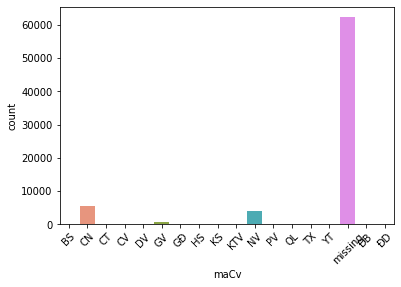

In [37]:
sns.countplot(x='maCv', data=object_columns_df)
plt.xticks(rotation=45)
plt.show()

In [38]:
missing_category = object_columns_df.isnull().sum()
missing_category = ['Field_1', 'Field_6', 'Field_7', 'Field_8', 'Field_25', 'Field_33', 'Field_40', 'Field_43', 'Field_44',
                    'F_startDate', 'F_endDate', 'E_startDate', 'E_endDate', 'C_startDate', 'C_endDate', 'G_startDate',
                    'G_endDate', 'A_startDate', 'A_endDate']

In [39]:
object_columns_df = object_columns_df.drop(missing_category, axis=1)

In [40]:
null_category = missing_values(object_columns_df)
null_category

Có tất cả 28 cột.
Trog đó có 0 cột bị thiếu data


,Missing,Percent %


In [41]:
object_columns_df.shape

(73411, 28)

In [42]:
object_columns_df

,Field_4,Field_12,Field_18,Field_32,diaChi,Field_36,Field_45,Field_46,Field_48,Field_54,Field_55,Field_56,Field_61,Field_65,Field_66,Field_68,maCv,currentLocationLocationId,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,currentLocationState,homeTownCity,homeTownName,homeTownState,brief,Giới Tính
0,gh,g8,trung tâm kinh doanh tiền mặt,2018-12-28,"23a bt1, bắc linh đàm, đại kim, hoàng mai, hà ...",dn,tf4354f,công ty tài chính tnhh mb shinsei,"tầng 9, tòa nhà mb, số 21 cát linh, đống đa, hn",vn,tf,ngoài quốc doanh quận đống đa,khối dn ngoài quốc doanh,vùng 1,g,0107349019,NV,nan,nan,nan,nan,nan,nan,nan,nan,nan,cb1,male
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,4,nan
2,t1,nan,nan,2019-01-17,"thôn khánh thọ, xã tam thái, huyện phú ninh, t...",dn,tb0648b,chi nhánh quảng nam- công ty cổ phần g-perform...,"tổ 2, khối châu trung, cẩm nam, hội an, quảng nam",nan,tb,ngoài quốc doanh thị xã hội an,khối dn ngoài quốc doanh,vùng 2,e,0107289017-001,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,female
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20376,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan
20377,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,nan
20378,gh,nan,nan,12/18/2018,"41, k.4, phường 4, thành phố cao lãnh, tỉnh đồ...",hc,ha0103a,"trường thpt chuyên nguyễn quang diêu, tp cao lãnh","đ.lê đại hành, p. mỹ phú, thành phố cao lãnh, ...",vn,ha,hành chánh sự nghiệp thành phố cao lãnh,"khối hs, đảng, đoàn",nan,d,1401647565,missing,108243000000000.0,108243000000000.0,cao lãnh,vietnam,cao lãnh,đồng tháp province,cao lãnh,cao lãnh,đồng tháp province,nan,female
20379,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,male


In [43]:
#column = ['currentLocationCity', 'currentLocationCountry', 'currentLocationName', 'currentLocationState', 'homeTownCity', 'homeTownName', 'homeTownState']
#for i in column:
#    sns.countplot(x=i, data=object_columns_df)
#    plt.xticks(rotation=45)
#    plt.show();

In [44]:
drop = ['Field_4', 'Field_12', 'Field_45', 'Field_36', 'Field_54', 'Field_55', 'Field_66', 
        'Field_68', 'Giới Tính', 'currentLocationState', 'homeTownCity', 'homeTownName', 'homeTownState', 'Field_32',
        'currentLocationLocationId']

object_columns_df = object_columns_df.drop(drop, axis=1)

In [45]:
object_columns_df.shape

(73411, 13)

In [46]:
object_columns_df

,Field_18,diaChi,Field_46,Field_48,Field_56,Field_61,Field_65,maCv,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,brief
0,trung tâm kinh doanh tiền mặt,"23a bt1, bắc linh đàm, đại kim, hoàng mai, hà ...",công ty tài chính tnhh mb shinsei,"tầng 9, tòa nhà mb, số 21 cát linh, đống đa, hn",ngoài quốc doanh quận đống đa,khối dn ngoài quốc doanh,vùng 1,NV,nan,nan,nan,nan,cb1
1,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,4
2,nan,"thôn khánh thọ, xã tam thái, huyện phú ninh, t...",chi nhánh quảng nam- công ty cổ phần g-perform...,"tổ 2, khối châu trung, cẩm nam, hội an, quảng nam",ngoài quốc doanh thị xã hội an,khối dn ngoài quốc doanh,vùng 2,missing,nan,nan,nan,nan,1
3,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,1
4,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20376,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,1
20377,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,2
20378,nan,"41, k.4, phường 4, thành phố cao lãnh, tỉnh đồ...","trường thpt chuyên nguyễn quang diêu, tp cao lãnh","đ.lê đại hành, p. mỹ phú, thành phố cao lãnh, ...",hành chánh sự nghiệp thành phố cao lãnh,"khối hs, đảng, đoàn",nan,missing,108243000000000.0,cao lãnh,vietnam,cao lãnh,nan
20379,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,nan


In [47]:
#category = object_columns_df.to_excel("/content/drive/My Drive/Colab Notebooks/data/category.xlsx")

#### 5.2 Deeling with numeric feature

In [48]:
numerical_columns_df

,id,label,Field_3,Field_19,Field_20,Field_23,Field_27,Field_28,Field_29,Field_39,Field_47,Field_58,Field_59,Field_60,Field_63,Field_64,Field_67,Field_69,Field_70,Field_71,Field_72,Field_74,Field_75,Field_76,Field_77,friendCount,subscriberCount,currentLocationLatitude,homeTownLatitude,topFriends,numOrg,F_numOrg,F_numQuery,E_numOrg,G_numOrg,A_numOrg,partner0_A,partner0_G,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,1.0,1.0,NaN,4258600.0,16.0,NaN,NaN,NaN,1.0,4.0,0.0,5.0,3.0,2.0,1.0,118410.0,0.00,0.49,0.245,0.49,NaN,5.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,704.0,6.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
2,2,0.0,2.0,NaN,5000000.0,10.0,NaN,NaN,NaN,1.0,0.0,0.0,5.0,3.0,3.0,2.0,1073365.0,0.58,0.77,0.675,0.19,1076.0,2.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,1.0,2.0,NaN,3.0,0.0,0.0,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1
4,4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20376,73406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,42.644640,-10.722222,-160.0,3,0
20377,73407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,13.740300,6.562500,0.0,3,0
20378,73408,NaN,1.0,4.136,6162640.0,172.0,NaN,NaN,24.0,1.0,NaN,0.0,6.0,4.0,0.0,NaN,164598.0,0.50,0.88,0.690,0.38,NaN,5.0,3.0,5.0,0.0,0.0,10.4529,10.4529,5.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,0
20379,73409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,0.0,NaN,NaN,5.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,0


In [49]:
numerical_columns_df.shape

(73411, 48)

In [50]:
miss_numeric = missing_values(numerical_columns_df)
miss_numeric

Có tất cả 48 cột.
Trog đó có 45 cột bị thiếu data


,Missing,Percent %
Field_28,70632,96.2
Field_27,70524,96.1
Field_19,69307,94.4
homeTownLatitude,56029,76.3
currentLocationLatitude,54414,74.1
Field_29,50981,69.4
Field_74,44993,61.3
topFriends,44841,61.1
Field_47,41229,56.2
Field_76,41055,55.9


In [51]:
missing_numeric = ['Field_28', 'Field_27', 'Field_19', 'homeTownLatitude', 'currentLocationLatitude',
                   'Field_29', 'Field_74']

In [52]:
numerical_columns_df = numerical_columns_df.drop(missing_numeric, axis=1)

Fill missng giá trị 0 cho những feature có dưới 30% độ thiếu hụt

In [53]:
numeric_columns_30 = ['label', 'A_numOrg', 'numOrg', 'partner0_A', 'partner0_G', 'partner1_A', 'partner3_A',
                      'partner3_D', 'partner5_A']

In [54]:
numerical_columns_df[numeric_columns_30] = numerical_columns_df[numeric_columns_30].fillna(0)

In [55]:
miss_numeric = missing_values(numerical_columns_df)
miss_numeric

Có tất cả 41 cột.
Trog đó có 29 cột bị thiếu data


,Missing,Percent %
topFriends,44841,61.1
Field_47,41229,56.2
Field_75,41055,55.9
Field_77,41055,55.9
Field_76,41055,55.9
Field_64,40681,55.4
subscriberCount,40229,54.8
friendCount,40229,54.8
Field_69,39810,54.2
F_numQuery,39602,53.9


Những columns còn lại fill bằng giá trị median()

In [56]:
def fill_median(df):
    for col in df.columns:
        median = df[col].median()
        df[col] = df[col].fillna(median)
    return df

In [57]:
numerical_columns_df = fill_median(numerical_columns_df)

In [58]:
numerical_columns_df.head()

,id,label,Field_3,Field_20,Field_23,Field_39,Field_47,Field_58,Field_59,Field_60,Field_63,Field_64,Field_67,Field_69,Field_70,Field_71,Field_72,Field_75,Field_76,Field_77,friendCount,subscriberCount,topFriends,numOrg,F_numOrg,F_numQuery,E_numOrg,G_numOrg,A_numOrg,partner0_A,partner0_G,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,1.0,1.0,4258600.0,16.0,1.0,4.0,0.0,5.0,3.0,2.0,1.0,118410.0,0.00,0.49,0.245,0.49,5.0,0.0,2.0,40.0,0.0,5.0,5.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
1,1,0.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,2.0,2.0,503560.5,0.20,0.41,0.300,0.15,6.0,2.0,2.0,40.0,0.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
2,2,0.0,2.0,5000000.0,10.0,1.0,0.0,0.0,5.0,3.0,3.0,2.0,1073365.0,0.58,0.77,0.675,0.19,2.0,0.0,2.0,40.0,0.0,5.0,5.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,3,0.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,2.0,2.0,503560.5,0.20,0.41,0.300,0.15,4.0,1.0,3.0,40.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1
4,4,1.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,2.0,2.0,503560.5,0.20,0.41,0.300,0.15,4.0,1.0,3.0,40.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1


In [59]:
numerical_columns_df.shape

(73411, 41)

### 6.Encode category

In [60]:
object_columns_df.head()

,Field_18,diaChi,Field_46,Field_48,Field_56,Field_61,Field_65,maCv,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,brief
0,trung tâm kinh doanh tiền mặt,"23a bt1, bắc linh đàm, đại kim, hoàng mai, hà ...",công ty tài chính tnhh mb shinsei,"tầng 9, tòa nhà mb, số 21 cát linh, đống đa, hn",ngoài quốc doanh quận đống đa,khối dn ngoài quốc doanh,vùng 1,NV,nan,nan,nan,nan,cb1
1,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,4
2,nan,"thôn khánh thọ, xã tam thái, huyện phú ninh, t...",chi nhánh quảng nam- công ty cổ phần g-perform...,"tổ 2, khối châu trung, cẩm nam, hội an, quảng nam",ngoài quốc doanh thị xã hội an,khối dn ngoài quốc doanh,vùng 2,missing,nan,nan,nan,nan,1
3,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,1
4,nan,nan,nan,nan,nan,nan,nan,missing,nan,nan,nan,nan,1


In [61]:
object_columns_df.dtypes

Field_18                  category
diaChi                    category
Field_46                  category
Field_48                  category
Field_56                  category
Field_61                  category
Field_65                  category
maCv                      category
homeTownLocationId        category
currentLocationCity       category
currentLocationCountry    category
currentLocationName       category
brief                     category
dtype: object

số lượng category trong mõi columns

In [62]:
app = object_columns_df.select_dtypes('category').apply(pd.Series.nunique, axis = 0)
app

Field_18                   8625
diaChi                    27459
Field_46                  17778
Field_48                  15570
Field_56                   1516
Field_61                     37
Field_65                     11
maCv                         18
homeTownLocationId         1580
currentLocationCity        1021
currentLocationCountry       52
currentLocationName        1276
brief                        21
dtype: int64

In [63]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in object_columns_df:
    if object_columns_df[col].dtype == 'category':
        # If 2 or fewer unique categories
        if len(list(object_columns_df[col].unique())) <= 27459:
            # Train on the training data
            le.fit(object_columns_df[col])
            # Transform both training and testing data
            object_columns_df[col] = le.transform(object_columns_df[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

13 columns were label encoded.


In [64]:
object_columns_df.describe()

,Field_18,diaChi,Field_46,Field_48,Field_56,Field_61,Field_65,maCv,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,brief
count,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000,73411.000000
mean,6200.088311,14011.570296,11290.517947,7673.667938,740.750446,16.949204,6.650202,13.488156,1368.483456,541.119519,35.325442,663.171541,4.976502
std,1313.737614,5395.952369,4176.899024,2905.827780,348.392027,4.974321,1.317702,3.974322,428.465308,137.733521,9.202854,173.935337,6.618145
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6559.000000,14038.000000,9165.500000,7897.000000,761.000000,13.000000,6.000000,15.000000,1579.000000,574.000000,30.000000,660.000000,1.000000
50%,6559.000000,14038.000000,13451.000000,7897.000000,763.000000,20.000000,6.000000,15.000000,1579.000000,574.000000,30.000000,660.000000,3.000000
75%,6559.000000,14038.000000,13451.000000,7897.000000,763.000000,20.000000,7.000000,15.000000,1579.000000,574.000000,51.000000,660.000000,5.000000
max,8624.000000,27458.000000,17777.000000,15569.000000,1515.000000,36.000000,10.000000,17.000000,1579.000000,1020.000000,51.000000,1275.000000,20.000000


### 7. Model

In [65]:
df_final = pd.concat([object_columns_df, numerical_columns_df], axis=1,sort=False)
df_final.head()

,Field_18,diaChi,Field_46,Field_48,Field_56,Field_61,Field_65,maCv,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,brief,id,label,Field_3,Field_20,Field_23,Field_39,Field_47,Field_58,Field_59,Field_60,Field_63,Field_64,Field_67,Field_69,Field_70,Field_71,Field_72,Field_75,Field_76,Field_77,friendCount,subscriberCount,topFriends,numOrg,F_numOrg,F_numQuery,E_numOrg,G_numOrg,A_numOrg,partner0_A,partner0_G,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,7850,4009,10752,12700,1207,13,7,10,1579,574,30,660,16,0,1.0,1.0,4258600.0,16.0,1.0,4.0,0.0,5.0,3.0,2.0,1.0,118410.0,0.00,0.49,0.245,0.49,5.0,0.0,2.0,40.0,0.0,5.0,5.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
1,6559,14038,13451,7897,763,20,6,15,1579,574,30,660,7,1,0.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,2.0,2.0,503560.5,0.20,0.41,0.300,0.15,6.0,2.0,2.0,40.0,0.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
2,6559,18343,1183,12827,1268,13,8,15,1579,574,30,660,1,2,0.0,2.0,5000000.0,10.0,1.0,0.0,0.0,5.0,3.0,3.0,2.0,1073365.0,0.58,0.77,0.675,0.19,2.0,0.0,2.0,40.0,0.0,5.0,5.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,6559,14038,13451,7897,763,20,6,15,1579,574,30,660,1,3,0.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,2.0,2.0,503560.5,0.20,0.41,0.300,0.15,4.0,1.0,3.0,40.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1
4,6559,14038,13451,7897,763,20,6,15,1579,574,30,660,1,4,1.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,2.0,2.0,503560.5,0.20,0.41,0.300,0.15,4.0,1.0,3.0,40.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1


In [66]:
df_final['id']

0            0
1            1
2            2
3            3
4            4
         ...  
20376    73406
20377    73407
20378    73408
20379    73409
20380    73410
Name: id, Length: 73411, dtype: int64

In [67]:
df_final = df_final.drop(['id',],axis=1)

In [68]:
df_train = df_final[df_final['train'] == 1]
df_train = df_train.drop(['train',],axis=1)


df_test = df_final[df_final['train'] == 0]
df_test = df_test.drop(['label'],axis=1)
df_test = df_test.drop(['train',],axis=1)

In [76]:
print(df_train.shape)
print(df_test.shape)

(53030, 52)
(20381, 51)


In [69]:
import numpy as np # linear algebra
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import re 
from IPython.display import display_html
import itertools
import math
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import *
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import linear_model

# Import Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

#Learning curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve


In [70]:
print('TRAINING')
print(df_train.info())
print('\n\nTEST')
print(df_test.info())

df_train.head(0)
df_test.head(0)

cnt = 0
d_type = ['float64', 'int64','object','dtype']

TRAINING
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53030 entries, 0 to 53029
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Field_18                53030 non-null  int64  
 1   diaChi                  53030 non-null  int64  
 2   Field_46                53030 non-null  int64  
 3   Field_48                53030 non-null  int64  
 4   Field_56                53030 non-null  int64  
 5   Field_61                53030 non-null  int64  
 6   Field_65                53030 non-null  int64  
 7   maCv                    53030 non-null  int64  
 8   homeTownLocationId      53030 non-null  int64  
 9   currentLocationCity     53030 non-null  int64  
 10  currentLocationCountry  53030 non-null  int64  
 11  currentLocationName     53030 non-null  int64  
 12  brief                   53030 non-null  int64  
 13  label                   53030 non-null  float64
 14  Field_3                 53030

In [71]:
X_train = df_train.drop(['label'], axis=1)
X_test = df_test
y_train = df_train['label']

In [72]:
y_train

0        1.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
53025    0.0
53026    0.0
53027    0.0
53028    0.0
53029    0.0
Name: label, Length: 53030, dtype: float64

In [73]:
# grid search
def GridSearchModel(X, Y, model, parameters, cv):
    CV_model = GridSearchCV(estimator = model, param_grid = parameters, cv = cv)
    CV_model.fit(X, Y)
    CV_model.cv_results_
    print("Best Score:", CV_model.best_score_," / Best parameters:", CV_model.best_params_)

def Confuse(y, y_pred, classes):
    cnf_matrix = confusion_matrix(y, y_pred)
    
    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis = 1)[:, np.newaxis]
    c_train = pd.DataFrame(cnf_matrix, index = classes, columns = classes)  

    ax = sns.heatmap(c_train, annot = True, square = True, cbar = False, 
                          fmt = '.2f', annot_kws = {"size": 20})
    return(ax, c_train)

# Learning curve
def LearningCurve(X, y, model, cv, train_sizes):

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = 4, 
                                                            train_sizes = train_sizes)

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std  = np.std(train_scores, axis = 1)
    test_scores_mean  = np.mean(test_scores, axis = 1)
    test_scores_std   = np.std(test_scores, axis = 1)
    
    train_Error_mean = np.mean(1- train_scores, axis = 1)
    train_Error_std  = np.std(1 - train_scores, axis = 1)
    test_Error_mean  = np.mean(1 - test_scores, axis = 1)
    test_Error_std   = np.std(1 - test_scores, axis = 1)

    Scores_mean = np.mean(train_scores_mean)
    Scores_std = np.mean(train_scores_std)
    
    _, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X, y, model)
    
    plt.figure(figsize = (16,4))
    plt.subplot(1,2,1)
    ax1 = Confuse(y, y_pred, classes)
    plt.subplot(1,2,2)
    plt.fill_between(train_sizes, train_Error_mean - train_Error_std,train_Error_mean + train_Error_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_Error_mean - test_Error_std, test_Error_mean + test_Error_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_Error_mean, 'o-', color = "r",label = "Training Error")
    plt.plot(train_sizes, test_Error_mean, 'o-', color = "g",label = "Cross-validation Error")
    plt.legend(loc = "best")
    plt.grid(True)
     
    return (model, Scores_mean, Scores_std )

def ApplyModel(X, y, model):
    
    model.fit(X, y)
    y_pred  = model.predict(X)

    Accuracy = round(np.median(cross_val_score(model, X, y, cv = cv)),2)*100
 
    Error   = 1 - Accuracy
    
    precision = precision_score(y_train, y_pred) * 100
    recall = recall_score(y_train, y_pred) * 100
    f1score = f1_score(y_train, y_pred) * 100
    
    return (model, y_pred, Accuracy, Error, precision, recall, f1score)  
    

def PrintResults(model, X, y, title):
    
    model, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X, y, model)
    
    _, Score_mean, Score_std = LearningCurve(X, y, model, cv, train_size)
    Score_mean, Score_std = Score_mean*100, Score_std*100
    
    
    print('Scoring Accuracy: %.2f %%'%(Accuracy))
    print('Scoring Mean: %.2f %%'%(Score_mean))
    print('Scoring Standard Deviation: %.4f %%'%(Score_std))
    print("Precision: %.2f %%"%(precision))
    print("Recall: %.2f %%"%(recall))
    print('f1-score: %.2f %%'%(f1score))
    
    Summary = pd.DataFrame({'Model': title,
                       'Accuracy': Accuracy, 
                       'Score Mean': Score_mean, 
                       'Score St Dv': Score_std, 
                       'Precision': precision, 
                       'Recall': recall, 
                       'F1-Score': f1score}, index = [0])
    return (model, Summary)

In [74]:
classes = ["Good", "Bad"]
cv = ShuffleSplit(n_splits = 100, test_size = 0.25, random_state = 0)
train_size = np.linspace(.1, 1.0, 15)

In [75]:
#Logistic Regresion
model = LogisticRegression()
model, Summary_LR = PrintResults(model, X_train, y_train, 'Logistic Regression')

y_train_LR = pd.Series(model.predict(X_train), name = "LR")
y_test_LR = pd.Series(model.predict(X_test), name = "LR")

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


KeyboardInterrupt: ignored

In [ ]:
# Random Forest
model = RandomForestClassifier(n_estimators = 10)
model,Summary_RF = PrintResults(model, X_train,y_train, 'Random Forest')
y_train_RF = pd.Series(model.predict(X_train), name = "RF")
y_test_RF = pd.Series(model.predict(X_test), name = "RF")

Đầu tiên là sẽ sử dụng RandomForest

In [ ]:
# Random Forest
model = RandomForestClassifier(n_estimators = 10, oob_score = True)
model, y_pred, Accuracy, Error, precision, recall, f1score = ApplyModel(X_train, y_train, model)
Priority = pd.DataFrame({'Feature': X_train.columns,'Importance':np.round(model.feature_importances_,3)})
Priority  = Priority .sort_values('Importance',ascending = False).set_index('Feature')

In [ ]:
Priority.head(15)

In [ ]:
model = RandomForestClassifier(n_estimators = 2, oob_score = True)
_, Summary_RF = PrintResults(model, X_train,y_train,'Random Forest')
y_test_RF = pd.Series(model.predict(X_test), name = 'label')
print("oob score:", round(model.oob_score_, 4) * 100, "%")

In [ ]:
model_rf_final = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'entropy',
            max_depth = 10, max_features = 'log2', max_leaf_nodes = None,
            min_impurity_decrease = 0.0, min_impurity_split = None,
            min_samples_leaf = 1, min_samples_split = 30,
            min_weight_fraction_leaf = 0.0, n_estimators = 100, n_jobs = 1,
            oob_score = False, random_state = None, verbose = 0, warm_start = False)

In [ ]:
_, Summary_LR = PrintResults(model_rf_final, X_train, y_train, 'RandomForest')
y_train_pred = pd.Series(model_rf_final.predict(X_train))
y_test_pred = pd.Series(model_rf_final.predict(X_test))

In [ ]:
y_test_pred = pd.Series(model_rf_final.predict(X_test), name = "label")

In [ ]:
y_test_pred_final = pd.DataFrame(y_test_pred)

In [ ]:
y_test_pred_final.head()

In [ ]:
sns.countplot(x='label', data=y_test_pred_final)
plt.xticks(rotation=45)
plt.show()